In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

import torch
import random

from sae.sparse_autoencoder import load_saved_sae
from sae.metrics import model_store_from_sae
from unlearning.metrics import convert_wmdp_data_to_prompt, convert_list_of_dicts_to_dict_of_lists
from unlearning.tool import UnlearningConfig, SAEUnlearningTool, MCQ_ActivationStoreAnalysis, ActivationStoreAnalysis
from unlearning.metrics import modify_and_calculate_metrics, calculate_metrics_list, create_df_from_metrics
from unlearning.feature_attribution import calculate_cache

from huggingface_hub import hf_hub_download
from datasets import load_dataset
import numpy as np
import pandas as pd
import itertools
from transformer_lens import utils

from jaxtyping import Float
from torch import Tensor

import einops

from pathlib import Path

import plotly.express as px
from unlearning.var import REPO_ID, SAE_MAPPING
import pickle
import matplotlib.pyplot as plt
from unlearning.metrics import all_permutations

from unlearning.metrics import calculate_metrics_side_effects
from unlearning.feature_attribution import find_topk_features_given_prompt, test_topk_features


In [3]:
# Load main SAE for gemma-2b-it
filename = hf_hub_download(repo_id=REPO_ID, filename=SAE_MAPPING['gemma_2b_it_resid_pre_9'])
sae = load_saved_sae(filename)
model = model_store_from_sae(sae)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model gemma-2b-it into HookedTransformer
Moving model to device:  cuda


In [4]:
# pass in the dataset as an argument so no need to load in everytime
dataset = load_dataset("cais/wmdp", "wmdp-bio", split='test')

answers = [x['answer'] for x in dataset]
questions = [x['question'] for x in dataset]
choices_list = [x['choices'] for x in dataset]

prompts = [convert_wmdp_data_to_prompt(question, choices, prompt_format=None)
           for question, choices in zip(questions, choices_list)]


In [5]:
# Hyper parameters for automation process
question_ids_correct = np.genfromtxt("../data/question_ids/gemma-2b-it/all/wmdp-bio_correct.csv", dtype=int)
questions_ids_correct_train = np.genfromtxt("../data/question_ids/gemma-2b-it/train/wmdp-bio_correct.csv", dtype=int)
topk_per_prompt = 20

unlearning_dataset = ['wmdp-bio']
side_effect_dataset_names =  ['high_school_us_history', 'college_computer_science', 'high_school_geography', 'human_aging', 'college_biology']
all_dataset_names = ['loss_added', 'wmdp-bio', 'high_school_us_history', 'college_computer_science', 'high_school_geography', 'human_aging', 'college_biology']


In [6]:
dataset_args = {
    'question_subset': question_ids_correct,
}

sae.cfg.n_batches_in_store_buffer = 86

act_store = MCQ_ActivationStoreAnalysis(sae.cfg, model, dataset_args=dataset_args)
unlearning_metric = 'wmdp-bio_gemma_2b_it_correct'

unlearn_cfg = UnlearningConfig(unlearn_activation_store=act_store, unlearning_metric=unlearning_metric)
ul_tool2 = SAEUnlearningTool(unlearn_cfg)
ul_tool2.setup(model=model)
ul_tool2.get_metrics_with_text()

dataloader
buffer
dataloader


100%|██████████| 43/43 [00:27<00:00,  1.54it/s]


tokens torch.Size([172, 1024]) 1024
tokens torch.Size([172, 1024])
Concatenating learned activations
Done


100%|██████████| 43/43 [00:07<00:00,  5.98it/s]


tokens torch.Size([172, 1024]) 1024
tokens torch.Size([172, 1024])
Concatenating learned activations
Done


In [7]:
good_features = np.loadtxt('../eoin_notebooks/feature_ids_zero_side_effect_sorted_gemma1_2b_all.csv', dtype=int)
good_features

/tmp/ipykernel_13641/484773700.py:1: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  good_features = np.loadtxt('../eoin_notebooks/feature_ids_zero_side_effect_sorted_gemma1_2b_all.csv', dtype=int)


array([13431,  7983,  4342,  6308, 15642, 11358,  8660,  9473,  9163,
        8596, 10051, 12044, 12273, 13443,  5205,  4654,  1557,    32,
       15755,  7076,  5525,  4071,  4687, 11147,  3599,  5861])

For each feature, plot number of question unlearned using the feature decoder and a random decoder

In [8]:
multipliers = [1, 5, 10, 20, 50, 100, 200]

In [11]:
# Calculate metrics

selected_feature = good_features[2]
main_ablate_params = {
                      'multiplier': 20,
                      'intervention_method': 'clamp_feature_activation',
                     }


sweep = {
         'features_to_ablate': [good_features],
         'multiplier': multipliers,
        }

metric_params = {'wmdp-bio': 
                 {
                       'question_subset': question_ids_correct,
                       'permutations': None,
                       'verbose': False,
                   }
                 }

dataset_names = all_dataset_names

n_batch_loss_added = 50

metrics = calculate_metrics_list(
    model,
    sae,
    main_ablate_params,
    sweep,
    dataset_names=dataset_names,
    metric_params=metric_params,
    include_baseline_metrics=False,
    split='all',
    verbose=False,
    activation_store=ul_tool2.base_activation_store,
    n_batch_loss_added=n_batch_loss_added
)


100%|██████████| 7/7 [11:02<00:00, 94.59s/it]


In [12]:
# Calculate metrics

selected_feature = good_features[2]
main_ablate_params = {
                      'multiplier': 20,
                      'intervention_method': 'clamp_feature_activation_random',
                     }


sweep = {
         'features_to_ablate': [good_features],
         'multiplier': multipliers,
        }

metric_params = {'wmdp-bio': 
                 {
                       'question_subset': question_ids_correct,
                       'permutations': None,
                       'verbose': False,
                   }
                 }

dataset_names = all_dataset_names

n_batch_loss_added = 50

metrics_random = calculate_metrics_list(
    model,
    sae,
    main_ablate_params,
    sweep,
    dataset_names=dataset_names,
    metric_params=metric_params,
    include_baseline_metrics=False,
    split='all',
    verbose=False,
    activation_store=ul_tool2.base_activation_store,
    n_batch_loss_added=n_batch_loss_added
)


  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [11:02<00:00, 94.71s/it]


In [15]:
import pickle

with open('../data/random_decoder_unlearn_metrics/zero_side_effect.pkl', 'wb') as f:
    pickle.dump(metrics, f)
    
with open('../data/random_decoder_unlearn_metrics/zero_side_effect_random.pkl', 'wb') as f:
    pickle.dump(metrics_random, f)

In [11]:
good_features

array([13431,  7983,  4342,  6308, 15642, 11358,  8660,  9473,  9163,
        8596, 10051, 12044, 12273, 13443,  5205,  4654,  1557,    32,
       15755,  7076,  5525,  4071,  4687, 11147,  3599,  5861])

In [16]:
base_unlearned = []
for metric in metrics:
    n_correct = metric['wmdp-bio']['total_correct']
    n_questions = len(metric['wmdp-bio']['is_correct'])
    
    n_unlearned = n_questions - n_correct
    base_unlearned.append(n_unlearned)
    
base_unlearned

[1, 4, 27, 60, 85, 94, 95]

In [17]:
random_unlearned = []
for metric in metrics_random:
    n_correct = metric['wmdp-bio']['total_correct']
    n_questions = len(metric['wmdp-bio']['is_correct'])
    
    n_unlearned = n_questions - n_correct
    random_unlearned.append(n_unlearned)
    
random_unlearned

[0, 7, 26, 77, 90, 82, 89]

In [18]:
model_name = model.cfg.model_name

In [19]:
import matplotlib as mpl
from cycler import cycler

mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 1.4

mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.major.width'] = 0.4
mpl.rcParams['xtick.minor.width'] = 0.4
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2

mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.major.width'] = 0.4
mpl.rcParams['ytick.minor.width'] = 0.4
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 2

mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['axes.labelsize'] = 10


mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.fontsize'] = 9

mpl.rcParams['figure.figsize'] = 6, 4

mpl.rcParams['axes.prop_cycle'] = cycler("color", ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Plotting
fig_dir = "../figs"

def create_lineplot_histogram(distribution, bins=20):
    vals, bin_edges = np.histogram(distribution, bins=bins)

    xvals = np.repeat(bin_edges, 2)
    yvals = np.repeat(vals, 2)
    yvals = np.concatenate(([0], yvals, [0]))

    return xvals, yvals

In [20]:
df = []

for multiplier, metric in zip(multipliers, metrics):
    row = {}
    n_se_correct_questions = 0
    n_se_questions = 0
    
    for dataset in metric:
        if dataset == 'loss_added':
            row[dataset] = metric[dataset]
        elif dataset == 'ablate_params':
            for k in metric[dataset]:
                row[k] = metric[dataset][k]
        else:
            row[dataset] = metric[dataset]['mean_correct']
            
            if dataset not in ['college_biology', 'wmdp-bio']:
                n_se_correct_questions += metric[dataset]['total_correct']
                n_se_questions += len(metric[dataset]['is_correct'])
    
    row['multiplier'] = multiplier
    row['all_side_effects_mcq'] = n_se_correct_questions / n_se_questions
    row['random_decoder'] = False
    df.append(row)
    
for multiplier, metric in zip(multipliers, metrics_random):
    row = {}
    n_se_correct_questions = 0
    n_se_questions = 0
    
    for dataset in metric:
        if dataset == 'loss_added':
            row[dataset] = metric[dataset]
        elif dataset == 'ablate_params':
            for k in metric[dataset]:
                row[k] = metric[dataset][k]
        else:
            row[dataset] = metric[dataset]['mean_correct']
            
            if dataset not in ['college_biology', 'wmdp-bio']:
                n_se_correct_questions += metric[dataset]['total_correct']
                n_se_questions += len(metric[dataset]['is_correct'])
    
    row['multiplier'] = multiplier
    row['all_side_effects_mcq'] = n_se_correct_questions / n_se_questions
    row['random_decoder'] = True
    df.append(row)
    
df = pd.DataFrame(df)
df

,loss_added,wmdp-bio,high_school_us_history,college_computer_science,high_school_geography,human_aging,college_biology,multiplier,all_side_effects_mcq,random_decoder
0,0.010546,0.994186,1.000000,1.0,1.0,1.0,1.000000,1,1.000000,False
1,0.023310,0.976744,1.000000,1.0,1.0,1.0,1.000000,5,1.000000,False
2,0.004101,0.843023,1.000000,1.0,1.0,1.0,1.000000,10,1.000000,False
3,-0.000170,0.651163,1.000000,1.0,1.0,1.0,0.866667,20,1.000000,False
4,0.273455,0.505814,1.000000,1.0,1.0,1.0,0.800000,50,1.000000,False
5,0.585005,0.453488,0.962963,1.0,1.0,1.0,0.800000,100,0.989691,False
6,1.733346,0.447674,0.962963,1.0,1.0,1.0,0.800000,200,0.989691,False
7,-0.000066,1.000000,1.000000,1.0,1.0,1.0,1.000000,1,1.000000,True
8,-0.001184,0.959302,1.000000,1.0,1.0,1.0,0.933333,5,1.000000,True
9,-0.002831,0.848837,1.000000,1.0,1.0,1.0,0.933333,10,1.000000,True


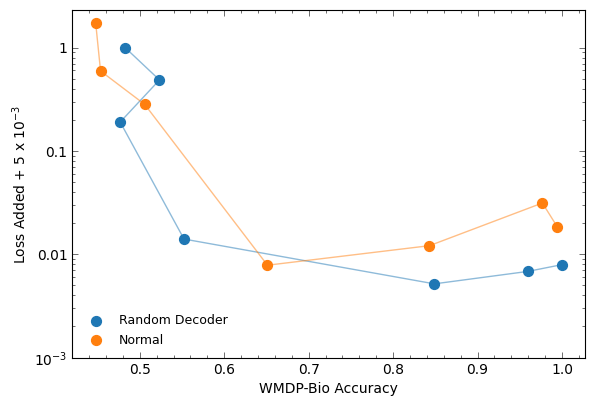

In [30]:
def plot_metrics(df, x_col, y_col, color_col, fig_name, rmu_df=None):
    fig, ax = plt.subplots(figsize=(6, 4))

    if y_col == 'loss_added':
        # y_min = df[y_col].min()
        # offset = abs(y_min) + 1e-4 if y_min <= 0 else 0
        # print(offset)
        offset = 8e-3
        
    
    for random in [True, False]:
        subset = df[df['random_decoder'] == random]
        color = colors[0] if random else colors[1]
        y_values = np.log10(subset[y_col] + offset)
        ax.plot(subset[x_col], y_values, c=color, alpha=0.5)
        ax.scatter(subset[x_col], y_values, c=color, label='Random Decoder' if random else 'Normal', s=50)
        
    
    yticks = [-4, -3, -2, -1, 0]
    yticklabels = [r"10$^{-4}$", r"10$^{-3}$", 0.01, 0.1, 1]
    yminor_ticks = np.log10(np.concatenate((np.arange(1e-4, 1e-3, 1e-4),
                                            np.arange(1e-3, 1e-2, 1e-3),
                                            np.arange(1e-2, 1e-1, 1e-2),
                                            np.arange(1e-1, 1, 1e-1))))

    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_yticks(yminor_ticks, minor=True)


    ax.legend(loc='lower left')

    ax.set_xlabel('WMDP-Bio Accuracy')
    ax.set_ylabel(f'Loss Added + 5 x 10$^{{-3}}$')
    
    ax.set_ylim(-3,)

    fig.subplots_adjust(right=0.98, top=0.98)
    fig.savefig(fig_dir + f"/random_decoder/{model_name}_{fig_name}.png", dpi=400)
    # plt.show()


plot_metrics(
    df, 
    x_col='wmdp-bio', 
    y_col='loss_added', 
    color_col='random_decoder', 
    fig_name='zero_side_effect_wmdp-bio_vs_loss_added_random_decoder',
)


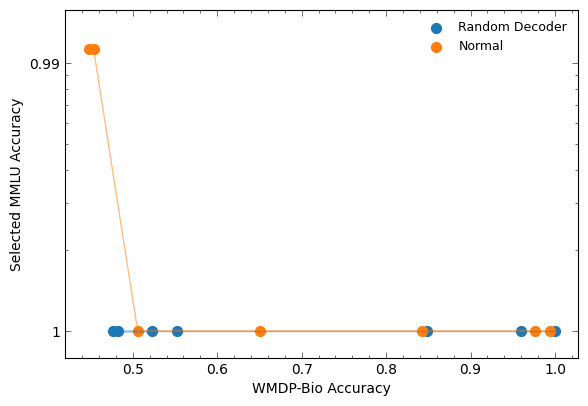

In [38]:
def plot_metrics(df, x_col, y_col, color_col, fig_name, rmu_df=None):
    fig, ax = plt.subplots(figsize=(6, 4))

        
    eps = 1e-3    
    for random in [True, False]:
        subset = df[df['random_decoder'] == random]
        color = colors[0] if random else colors[1]
        y_values = np.log10(1 - subset[y_col] + eps)
        ax.plot(subset[x_col], y_values, c=color, alpha=0.5)
        ax.scatter(subset[x_col], y_values, c=color, label='Random Decoder' if random else 'Normal', s=50)
        
    
    yticks = [-3, -2, -1]
    yticklabels = [1, 0.99, 0.9]
    yminor_ticks = np.log10(np.concatenate((np.arange(1e-3, 1e-2, 1e-3),
                                            np.arange(1e-2, 1e-1, 1e-2),
                                            np.arange(1e-1, 1, 1e-1))))

    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_yticks(yminor_ticks, minor=True)
    
    ax.legend()

    ax.set_xlabel('WMDP-Bio Accuracy')
    ax.set_ylabel(f'Selected MMLU Accuracy')
    ax.set_ylim(-3.1, -1.8)

    fig.subplots_adjust(right=0.98, top=0.98)
    fig.savefig(fig_dir + f"/random_decoder/{model_name}_{fig_name}.png", dpi=400)
    # plt.show()


plot_metrics(
    df, 
    x_col='wmdp-bio', 
    y_col='all_side_effects_mcq', 
    color_col='random_decoder', 
    fig_name='zero_side_effect_wmdp-bio_vs_side_efffect_mcq_random_decoder',
)


In [27]:
df

,loss_added,wmdp-bio,high_school_us_history,college_computer_science,high_school_geography,human_aging,college_biology,multiplier,all_side_effects_mcq,random_decoder
0,0.010546,0.994186,1.000000,1.0,1.0,1.0,1.000000,1,1.000000,False
1,0.023310,0.976744,1.000000,1.0,1.0,1.0,1.000000,5,1.000000,False
2,0.004101,0.843023,1.000000,1.0,1.0,1.0,1.000000,10,1.000000,False
3,-0.000170,0.651163,1.000000,1.0,1.0,1.0,0.866667,20,1.000000,False
4,0.273455,0.505814,1.000000,1.0,1.0,1.0,0.800000,50,1.000000,False
5,0.585005,0.453488,0.962963,1.0,1.0,1.0,0.800000,100,0.989691,False
6,1.733346,0.447674,0.962963,1.0,1.0,1.0,0.800000,200,0.989691,False
7,-0.000066,1.000000,1.000000,1.0,1.0,1.0,1.000000,1,1.000000,True
8,-0.001184,0.959302,1.000000,1.0,1.0,1.0,0.933333,5,1.000000,True
9,-0.002831,0.848837,1.000000,1.0,1.0,1.0,0.933333,10,1.000000,True
